In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import re

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### 1.EDA 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [5]:
df.describe(include="object")

,title,author,text
count,20242,18843,20761
unique,19803,4201,20386
top,Get Ready For Civil Unrest: Survey Finds That ...,Pam Key,
freq,5,243,75


In [6]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.reset_index(inplace=True)

In [9]:
df.duplicated().sum()

0

In [10]:
df['label'].value_counts()

0    10361
1     7924
Name: label, dtype: int64

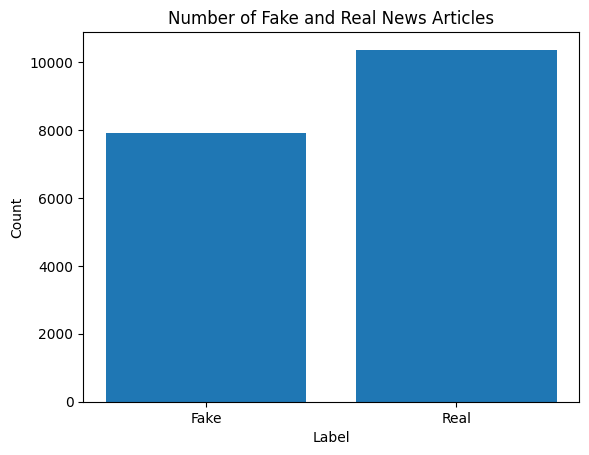

In [11]:
# Get the number of fake and real news articles
num_fake = len(df[df['label'] == 1])
num_real = len(df[df['label'] == 0])

# Create a bar chart to show the number of fake and real news articles
labels = ['Fake', 'Real']
values = [num_fake, num_real]
plt.bar(labels, values)
plt.title('Number of Fake and Real News Articles')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

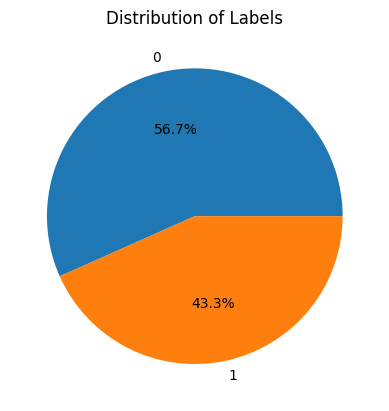

In [12]:
# Create a pie chart of the distribution of the label column
label_counts = df['label'].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Labels')
plt.show()


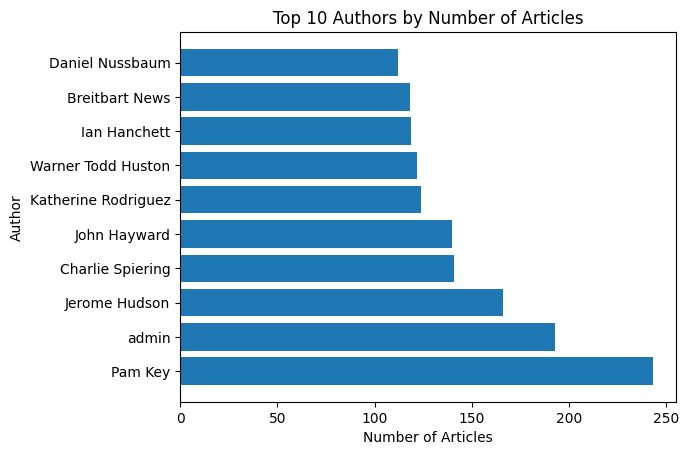

In [13]:
# Get the top 10 authors by number of articles
top_authors = df['author'].value_counts()[:10]

# Create a horizontal bar chart to show the top authors
plt.barh(top_authors.index, top_authors.values)
plt.title('Top 10 Authors by Number of Articles')
plt.xlabel('Number of Articles')
plt.ylabel('Author')
plt.show()

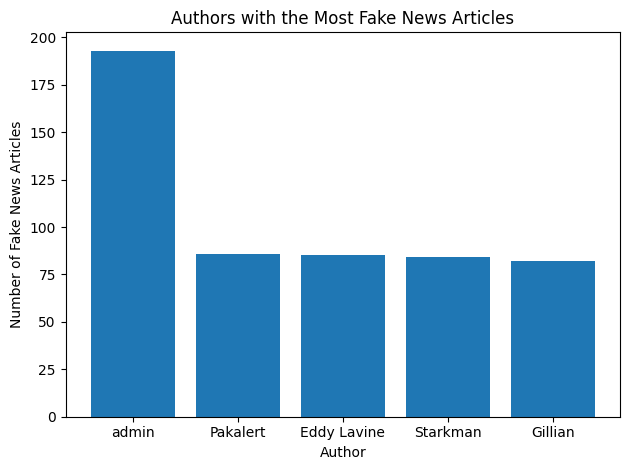

In [14]:
# Filter the DataFrame to include only fake news articles
fake_df = df[df['label'] == 1]

# Group the articles by author and count the number of articles written by each author
fake_counts = fake_df['author'].value_counts()

# Get the top 5 authors with the most fake news articles
top_authors = fake_counts[:5]

# Plot the top authors with the most fake news articles
plt.bar(top_authors.index, top_authors.values)
plt.title('Authors with the Most Fake News Articles')
plt.xlabel('Author')
plt.ylabel('Number of Fake News Articles')
plt.tight_layout()
plt.show()

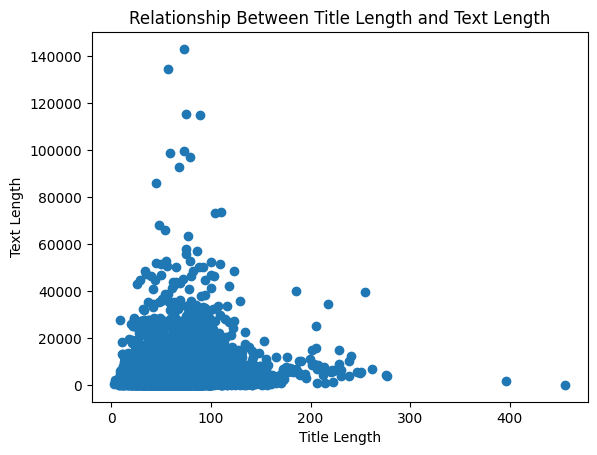

In [15]:
# Calculate the length of each news article's title and text
df['title_length'] = df['title'].apply(len)
df['text_length'] = df['text'].apply(len)

# Create a scatter plot to show the relationship between title length and text length
plt.scatter(df['title_length'], df['text_length'])
plt.title('Relationship Between Title Length and Text Length')
plt.xlabel('Title Length')
plt.ylabel('Text Length')
plt.show()

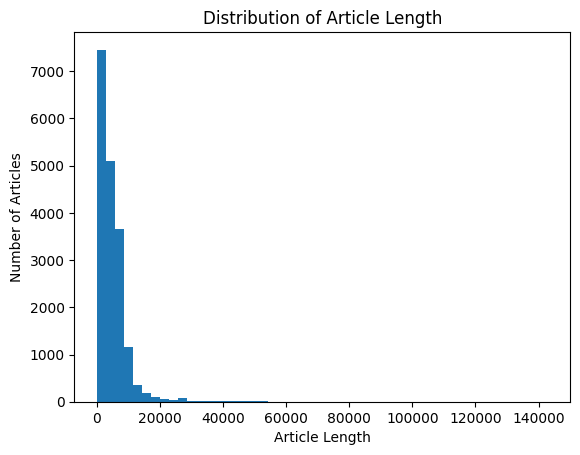

In [16]:
# Create a histogram of the article length
plt.hist(df['text_length'], bins=50)
plt.title('Distribution of Article Length')
plt.xlabel('Article Length')
plt.ylabel('Number of Articles')
plt.show()

array([<AxesSubplot: title={'center': '0'}>,
       <AxesSubplot: title={'center': '1'}>], dtype=object)

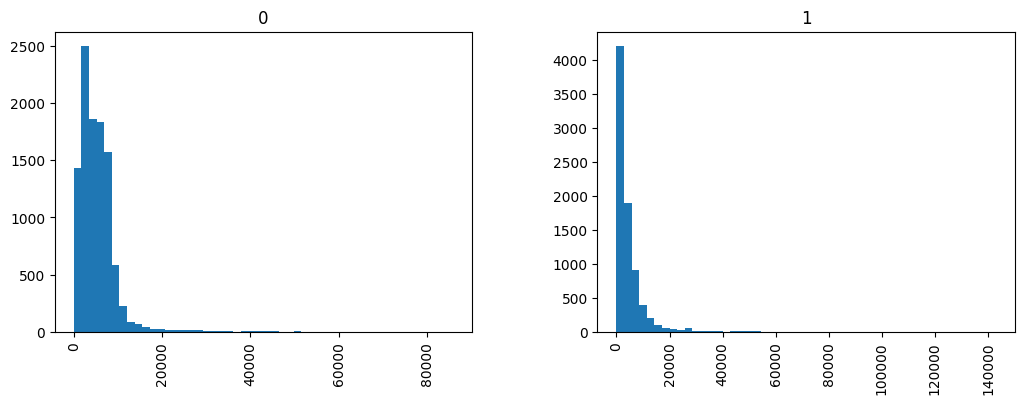

In [17]:
df.hist(column='text_length', by='label', bins=50,figsize=(12,4))

In [18]:
df.text_length.describe()

count     18285.000000
mean       4800.181843
std        5225.865069
min           1.000000
25%        1834.000000
50%        3694.000000
75%        6535.000000
max      142961.000000
Name: text_length, dtype: float64

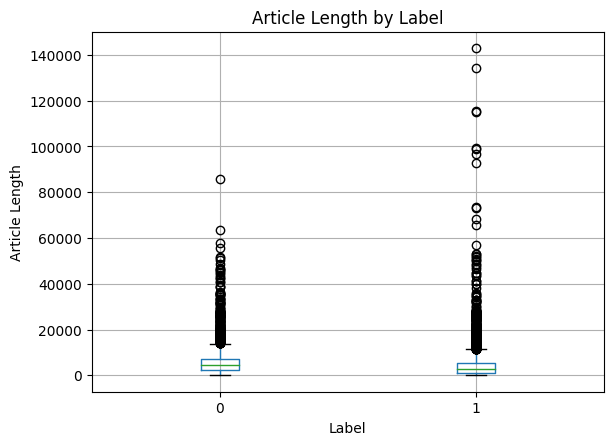

In [19]:
# Create a box plot of article length by label
df.boxplot(column='text_length', by='label')
plt.title('Article Length by Label')
plt.suptitle('')
plt.xlabel('Label')
plt.ylabel('Article Length')
plt.show()


### 2. Text Preprocessing

In [20]:
df.head()

,index,id,title,author,text,label,title_length,text_length
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,81,4930
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,55,4160
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,33,7692
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,63,3237
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,93,938


In [21]:
# create corpus
def create_corpus(df,target):
    corpus=[]
    
    for x in df[df['label']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [22]:
create_corpus(df,1)[:10]

['House',
 'Dem',
 'Aide:',
 'We',
 'Didn’t',
 'Even',
 'See',
 'Comey’s',
 'Letter',
 'Until']

In [23]:
from nltk.corpus import stopwords
stop = set(stopwords.words("english"))

In [24]:
from collections import defaultdict
corpus0 = create_corpus (df,0)
corpusl= create_corpus (df,1)
d0 = defaultdict(int)
for word in corpus0:
     if word in stop:
         d0[word] += 1
d1 = defaultdict(int)
for word in corpusl:
     if word in stop:
        d1[word] += 1


In [25]:
top0 = sorted(d0.items(), key=lambda x: x[1], reverse=True)[:10]
top1 = sorted(d1.items(), key=lambda x: x[1], reverse=True)[:10]

In [26]:
x0 ,y0= zip(*top0)
x1,y1= zip(*top1)

<BarContainer object of 10 artists>

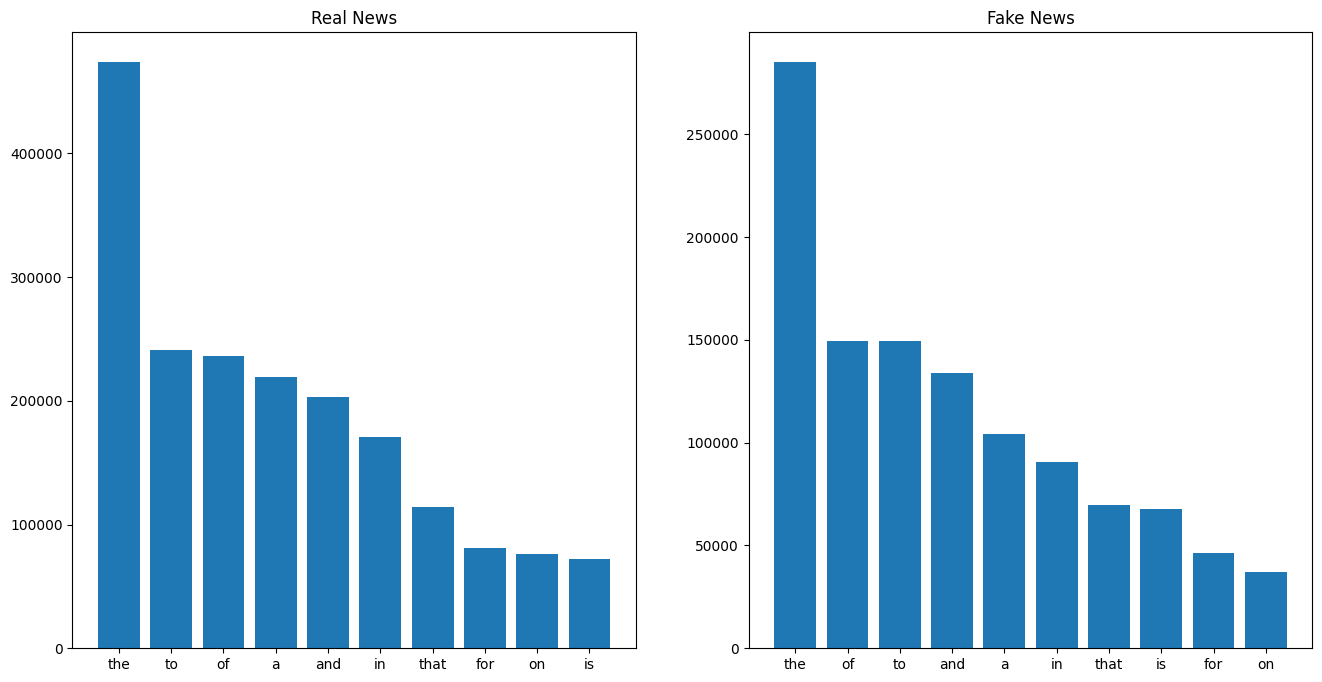

In [27]:
#top 10 stopwords in real and fake news 
plt.figure(1, figsize= (16, 8) )
plt.subplot(1, 2, 1)
plt.bar(x0, y0)
plt.title("Real News")
plt.subplot(1, 2, 2)
plt.title("Fake News")
plt.bar(x1, y1)


In [28]:
s0=defaultdict(int)
s1=defaultdict(int)
for word in corpus0:
    if word in string.punctuation:
        s0[word] += 1
for word in corpusl:
    if word in string.punctuation:
        s1[word] += 1

In [29]:
punc0 = sorted(s0.items(), key=lambda x: x[1], reverse=True)[:10]
punc1 = sorted(s1.items(), key=lambda x: x[1], reverse=True)[:10]
x0 ,y0= zip(*punc0)
x1,y1= zip(*punc1)

<BarContainer object of 10 artists>

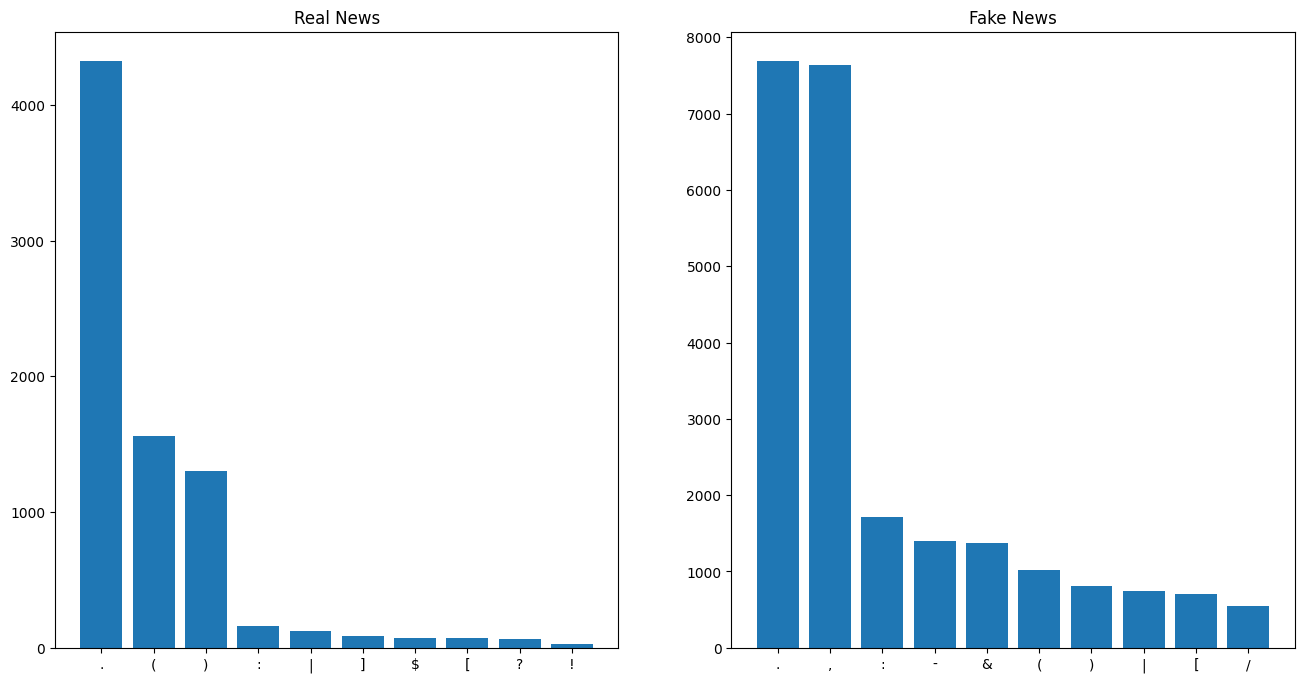

In [30]:
#top 10 punctuations in real and fake news 
plt.figure(1, figsize= (16, 8) )
plt.subplot(1, 2, 1)
plt.bar(x0, y0)
plt.title("Real News")
plt.subplot(1, 2, 2)
plt.title("Fake News")
plt.bar(x1, y1)

In [32]:
# Removing punctuation, stopwords and performing stemming
ps = PorterStemmer()
corpus = [] 
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    review = review.lower()
    review = review.split()
    review =[ps.stem(word) for word in review if word not in stopwords.words("english")]
    review=" ".join(review)
    corpus.append(review)

KeyboardInterrupt: 

In [ ]:
df['text']

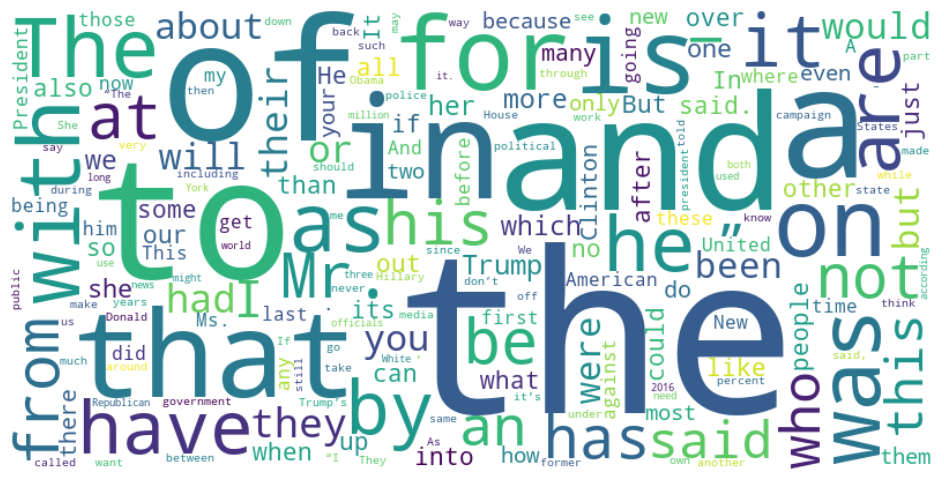

In [ ]:
from wordcloud import WordCloud
from collections import Counter

# Create a list of words in the text column of the dataframe
words = [word for article in df['text'] for word in article.split()]

# Count the frequency of each word using the Counter object
word_counts = Counter(words)

# Create a word cloud of the most common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
